# Analyse des données

In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from pathlib import Path

# Configuration
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 128

class DataAnalyzer:
    """Classe dédiée à l'analyse des données brutes"""
    def __init__(self):
        self.dataset = None
        self.info = None
        
    def load_data(self):
        """Charge le dataset brut pour analyse"""
        self.dataset, self.info = tfds.load(
            'malaria',
            split='train',
            with_info=True,
            as_supervised=True
        )

    def show_dataset_info(self):
        """Affiche les informations du dataset"""
        print("\nInformations détaillées du dataset:")
        print(f"Nombre total d'exemples: {self.info.splits['train'].num_examples}")
        print(f"Caractéristiques: {self.info.features}")
        print(f"Noms des classes: {self.info.features['label'].names}")
        
    def plot_class_distribution(self):
        """Affiche la distribution des classes"""
        # Utiliser le dataset brut
        raw_dataset = tfds.load('malaria', split='train', as_supervised=True)
        
        # Utiliser tf.stack au lieu de tf.concat pour les scalaires
        labels = tf.stack([label for _, label in raw_dataset], axis=0)
        
        # Obtenir le compte des classes
        unique, counts = np.unique(labels.numpy(), return_counts=True)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=[self.info.features['label'].names[i] for i in unique],
                   y=counts)
        plt.title('Distribution des Classes')
        plt.ylabel('Nombre d\'images')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def show_sample_images(self, num_samples=3):
        """Affiche des exemples d'images brutes"""
        # Utiliser le dataset brut
        raw_dataset = tfds.load('malaria', split='train', as_supervised=True)
        
        plt.figure(figsize=(15, 5))
        for i, (image, label) in enumerate(raw_dataset.take(num_samples)):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(f'Classe: {self.info.features["label"].names[label]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    def analyze_image_sizes(self):
        """Analyse la distribution des tailles d'images originales"""
        heights = []
        widths = []
        aspect_ratios = []
        total_pixels = []
        
        print("\nAnalyse des dimensions des images...")
        
        # Correction ici : on charge directement le dataset sans [0]
        raw_dataset = tfds.load('malaria', split='train', as_supervised=True)
        for image, _ in raw_dataset:
            shape = tf.shape(image)
            h, w = shape[0], shape[1]
            heights.append(h.numpy())
            widths.append(w.numpy())
            aspect_ratios.append(w.numpy() / h.numpy())
            total_pixels.append((w.numpy() * h.numpy()))
        
        heights = np.array(heights)
        widths = np.array(widths)
        aspect_ratios = np.array(aspect_ratios)
        total_pixels = np.array(total_pixels)
        
        # Statistiques détaillées
        print("\nStatistiques des dimensions:")
        print("\nHauteur (pixels):")
        print(f"  - Min: {heights.min()}")
        print(f"  - Max: {heights.max()}")
        print(f"  - Moyenne: {heights.mean():.2f}")
        print(f"  - Médiane: {np.median(heights):.2f}")
        print(f"  - Écart-type: {heights.std():.2f}")
        
        print("\nLargeur (pixels):")
        print(f"  - Min: {widths.min()}")
        print(f"  - Max: {widths.max()}")
        print(f"  - Moyenne: {widths.mean():.2f}")
        print(f"  - Médiane: {np.median(widths):.2f}")
        print(f"  - Écart-type: {widths.std():.2f}")
        
        print("\nRatio d'aspect (largeur/hauteur):")
        print(f"  - Min: {aspect_ratios.min():.2f}")
        print(f"  - Max: {aspect_ratios.max():.2f}")
        print(f"  - Moyenne: {aspect_ratios.mean():.2f}")
        print(f"  - Médiane: {np.median(aspect_ratios):.2f}")
        
        print("\nNombre total de pixels:")
        print(f"  - Min: {total_pixels.min():,}")
        print(f"  - Max: {total_pixels.max():,}")
        print(f"  - Moyenne: {total_pixels.mean():,.2f}")
        
        # Créer une figure avec plusieurs sous-graphiques
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Distribution des hauteurs
        sns.histplot(heights, ax=ax1, bins=30)
        ax1.set_title('Distribution des hauteurs')
        ax1.set_xlabel('Hauteur (pixels)')
        
        # Distribution des largeurs
        sns.histplot(widths, ax=ax2, bins=30)
        ax2.set_title('Distribution des largeurs')
        ax2.set_xlabel('Largeur (pixels)')
        
        # Distribution des ratios d'aspect
        sns.histplot(aspect_ratios, ax=ax3, bins=30)
        ax3.set_title('Distribution des ratios d\'aspect')
        ax3.set_xlabel('Ratio largeur/hauteur')
        
        # Relation hauteur/largeur
        sns.scatterplot(x=widths, y=heights, ax=ax4, alpha=0.5)
        ax4.set_title('Hauteur vs Largeur')
        ax4.set_xlabel('Largeur (pixels)')
        ax4.set_ylabel('Hauteur (pixels)')
        
        plt.tight_layout()
        plt.show()
        
        # Afficher les dimensions les plus courantes
        print("\nDimensions les plus fréquentes (hauteur × largeur):")
        dimensions = [(h, w) for h, w in zip(heights, widths)]
        unique_dims, counts = np.unique(dimensions, axis=0, return_counts=True)
        sorted_indices = np.argsort(-counts)  # Tri décroissant
        for idx in sorted_indices[:5]:
            h, w = unique_dims[idx]
            count = counts[idx]
            percentage = (count / len(dimensions)) * 100
            print(f"  {h} × {w}: {count} images ({percentage:.1f}%)")

    def analyze_image_characteristics(self):
        """Analyse les caractéristiques des images (luminosité, contraste, etc.)"""
        brightness = []
        contrast = []
        brightness_by_class = {'parasitized': [], 'uninfected': []}
        contrast_by_class = {'parasitized': [], 'uninfected': []}
        
        # Utiliser le dataset brut au lieu de self.ds_train
        raw_dataset = tfds.load('malaria', split='train', as_supervised=True)
        dataset_sample = list(raw_dataset.take(100))
        
        if not dataset_sample:
            print("Aucune donnée dans le dataset")
            return
        
        # Itérer sur les batches et leurs images
        for batch_images, batch_labels in dataset_sample:
            # Assure-toi que batch_labels est un tenseur avec une dimension supplémentaire
            batch_labels = tf.reshape(batch_labels, [-1])
            
            # Pour chaque image dans le batch
            for image, label in zip(batch_images, batch_labels):
                # Convertir l'image en float32 avant les calculs
                image = tf.cast(image, tf.float32)
                label_name = self.info.features['label'].names[label]
                
                # Calculer la luminosité moyenne
                bright = float(tf.reduce_mean(image))
                brightness.append(bright)
                brightness_by_class[label_name].append(bright)
                
                # Calculer le contraste (écart-type des pixels)
                cont = float(tf.math.reduce_std(image))
                contrast.append(cont)
                contrast_by_class[label_name].append(cont)
        
        # Vérifie si les listes ne sont pas vides
        if not brightness or not contrast:
            print("Aucune donnée collectée pour la luminosité ou le contraste.")
            return
        
        # Créer une figure avec plusieurs sous-graphiques
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
        
        # Distribution de la luminosité
        sns.histplot(brightness, ax=ax1, bins=30)
        ax1.set_title('Distribution de la luminosité')
        ax1.set_xlabel('Luminosité moyenne')
        
        # Distribution du contraste
        sns.histplot(contrast, ax=ax2, bins=30)
        ax2.set_title('Distribution du contraste')
        ax2.set_xlabel('Contraste (écart-type)')
        
        # Relation luminosité/contraste
        sns.scatterplot(x=brightness, y=contrast, ax=ax3)
        ax3.set_title('Luminosité vs Contraste')
        ax3.set_xlabel('Luminosité')
        ax3.set_ylabel('Contraste')
        
        # Box plot de la luminosité par classe
        brightness_data = []
        brightness_labels = []
        for label_name, values in brightness_by_class.items():
            brightness_data.extend(values)
            brightness_labels.extend([label_name] * len(values))
        
        sns.boxplot(x=brightness_labels, y=brightness_data, ax=ax4)
        ax4.set_title('Distribution de la luminosité par classe')
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
        
        # Box plot du contraste par classe
        contrast_data = []
        contrast_labels = []
        for label_name, values in contrast_by_class.items():
            contrast_data.extend(values)
            contrast_labels.extend([label_name] * len(values))
        
        sns.boxplot(x=contrast_labels, y=contrast_data, ax=ax5)
        ax5.set_title('Distribution du contraste par classe')
        ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
        
        # Violin plot combiné luminosité/contraste par classe
        sns.violinplot(x=brightness_labels, y=brightness_data, ax=ax6, color='blue', alpha=0.3, label='Luminosité')
        ax6_twin = ax6.twinx()
        sns.violinplot(x=contrast_labels, y=contrast_data, ax=ax6_twin, color='red', alpha=0.3, label='Contraste')
        ax6.set_title('Distribution combinée luminosité/contraste par classe')
        ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)
        
        # Ajouter une légende pour le violin plot combiné
        lines1, labels1 = ax6.get_legend_handles_labels()
        lines2, labels2 = ax6_twin.get_legend_handles_labels()
        ax6.legend(lines1 + lines2, ['Luminosité', 'Contraste'])
        
        plt.tight_layout()
        plt.show()
        
        # Afficher les statistiques
        print("\nStatistiques par classe:")
        for label_name in brightness_by_class.keys():
            print(f"\nClasse: {label_name}")
            print(f"Luminosité - Moyenne: {np.mean(brightness_by_class[label_name]):.3f}, "
                  f"Écart-type: {np.std(brightness_by_class[label_name]):.3f}")
            print(f"Contraste  - Moyenne: {np.mean(contrast_by_class[label_name]):.3f}, "
                  f"Écart-type: {np.std(contrast_by_class[label_name]):.3f}")

    def analyze_class_balance(self):
        """Analyse l'équilibre des classes et calcule des métriques sur l'ensemble du dataset"""
        # Charger le dataset complet
        full_dataset = tfds.load('malaria', split='train', as_supervised=True)
        
        # Extraire les labels
        labels = tf.stack([label for _, label in full_dataset], axis=0)
        unique, counts = np.unique(labels.numpy(), return_counts=True)
        
        total = np.sum(counts)
        proportions = counts / total
        
        print("\nAnalyse de l'équilibre des classes sur l'ensemble du dataset:")
        for i, (count, prop) in enumerate(zip(counts, proportions)):
            class_name = self.info.features['label'].names[unique[i]]
            print(f"{class_name}:")
            print(f"  - Nombre d'images: {count}")
            print(f"  - Proportion: {prop:.2%}")
        
        # Calculer l'indice de déséquilibre
        imbalance_ratio = np.max(counts) / np.min(counts)
        print(f"\nRatio de déséquilibre (max/min): {imbalance_ratio:.2f}")

    def analyze_color_distribution(self):
        """Analyse la distribution des couleurs par canal et par classe"""
        # Dictionnaires pour stocker les statistiques par classe
        red_stats = {'parasitized': [], 'uninfected': []}
        green_stats = {'parasitized': [], 'uninfected': []}
        blue_stats = {'parasitized': [], 'uninfected': []}
        color_variance = {'parasitized': [], 'uninfected': []}
        
        # Prendre un échantillon du dataset
        raw_dataset = tfds.load('malaria', split='train', as_supervised=True)
        
        for image, label in raw_dataset.take(1000):  # Analyser 1000 images
            # Normaliser l'image
            image = tf.cast(image, tf.float32) / 255.0
            label_name = self.info.features['label'].names[label]
            
            # Calculer les moyennes par canal
            red_mean = tf.reduce_mean(image[:,:,0])
            green_mean = tf.reduce_mean(image[:,:,1])
            blue_mean = tf.reduce_mean(image[:,:,2])
            
            # Calculer la variance des couleurs (mesure d'uniformité)
            color_var = tf.reduce_mean(tf.math.reduce_std(image, axis=-1))
            
            # Stocker les statistiques
            red_stats[label_name].append(float(red_mean))
            green_stats[label_name].append(float(green_mean))
            blue_stats[label_name].append(float(blue_mean))
            color_variance[label_name].append(float(color_var))
        
        # Créer les visualisations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Distribution du canal rouge
        sns.kdeplot(data=red_stats['parasitized'], ax=ax1, label='Parasitée', color='red', alpha=0.5)
        sns.kdeplot(data=red_stats['uninfected'], ax=ax1, label='Saine', color='blue', alpha=0.5)
        ax1.set_title('Distribution du canal Rouge')
        ax1.legend()
        
        # Distribution du canal vert
        sns.kdeplot(data=green_stats['parasitized'], ax=ax2, label='Parasitée', color='red', alpha=0.5)
        sns.kdeplot(data=green_stats['uninfected'], ax=ax2, label='Saine', color='blue', alpha=0.5)
        ax2.set_title('Distribution du canal Vert')
        ax2.legend()
        
        # Distribution du canal bleu
        sns.kdeplot(data=blue_stats['parasitized'], ax=ax3, label='Parasitée', color='red', alpha=0.5)
        sns.kdeplot(data=blue_stats['uninfected'], ax=ax3, label='Saine', color='blue', alpha=0.5)
        ax3.set_title('Distribution du canal Bleu')
        ax3.legend()
        
        # Distribution de la variance des couleurs
        sns.kdeplot(data=color_variance['parasitized'], ax=ax4, label='Parasitée', color='red', alpha=0.5)
        sns.kdeplot(data=color_variance['uninfected'], ax=ax4, label='Saine', color='blue', alpha=0.5)
        ax4.set_title('Variance des Couleurs (uniformité)')
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Afficher quelques statistiques
        print("\nStatistiques des couleurs par classe:")
        for classe in ['parasitized', 'uninfected']:
            print(f"\nClasse: {classe}")
            print(f"Canal Rouge - Moyenne: {np.mean(red_stats[classe]):.3f}, Écart-type: {np.std(red_stats[classe]):.3f}")
            print(f"Canal Vert - Moyenne: {np.mean(green_stats[classe]):.3f}, Écart-type: {np.std(green_stats[classe]):.3f}")
            print(f"Canal Bleu - Moyenne: {np.mean(blue_stats[classe]):.3f}, Écart-type: {np.std(blue_stats[classe]):.3f}")
            print(f"Variance des couleurs - Moyenne: {np.mean(color_variance[classe]):.3f}, Écart-type: {np.std(color_variance[classe]):.3f}")



# Création du dossier de sortie pour les visualisations
output_dir = Path('outputs/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)

# Analyse des données
analyzer = DataAnalyzer()
analyzer.load_data()

## Analyses avant prétraitement
### Informations sur le dataset
> Commençons par examiner les informations de base sur notre dataset. Cela nous donnera une vue d'ensemble des données avec lesquelles nous allons travailler, comme le nombre total d'exemples et les caractéristiques des images.


In [14]:
analyzer.show_dataset_info()


Informations détaillées du dataset:
Nombre total d'exemples: 27558
Caractéristiques: FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
Noms des classes: ['parasitized', 'uninfected']


### Distribution des classes
> Examinons maintenant la distribution des classes dans notre dataset. Cela nous permettra de voir si nos données sont équilibrées ou s'il y a des classes sous-représentées. Un déséquilibre important pourrait nécessiter des techniques spécifiques pendant l'entraînement.


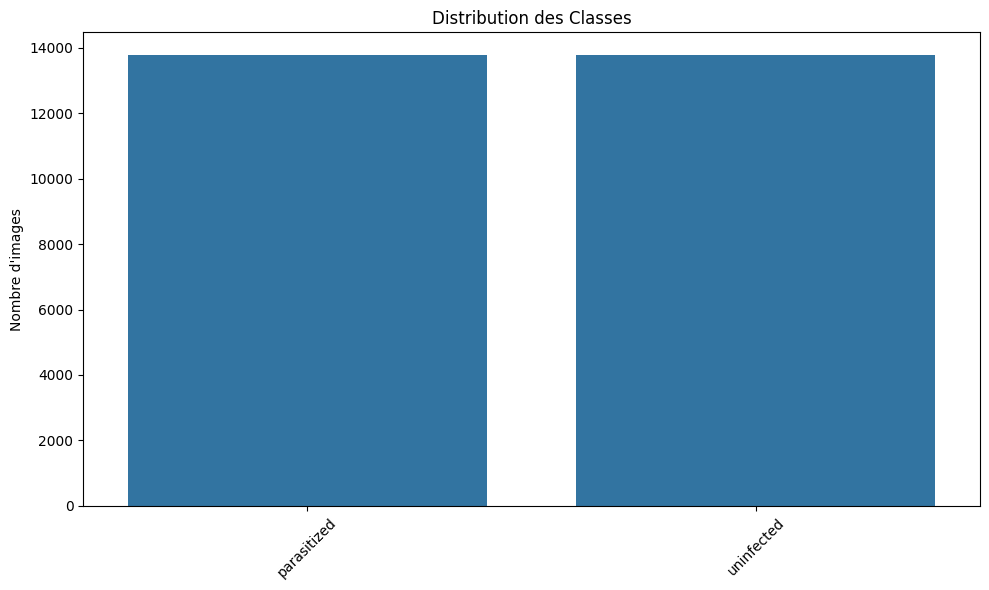

In [15]:
analyzer.plot_class_distribution()

> Le graphique ci-dessus montre la distribution des classes dans notre dataset de cellules sanguines. On peut observer que les données sont relativement équilibrées entre les deux classes (parasitées et non parasitées). Cette distribution équilibrée est un point positif car elle signifie qu'on n'aura pas besoin d'appliquer des techniques particulières pour gérer un déséquilibre des classes pendant l'entraînement du modèle. Les deux classes ayant une représentation similaire, le modèle pourra apprendre de manière équitable les caractéristiques de chaque type de cellule.


### Exemples d'images
> Pour mieux comprendre les données, examinons quelques exemples d'images de chaque classe.


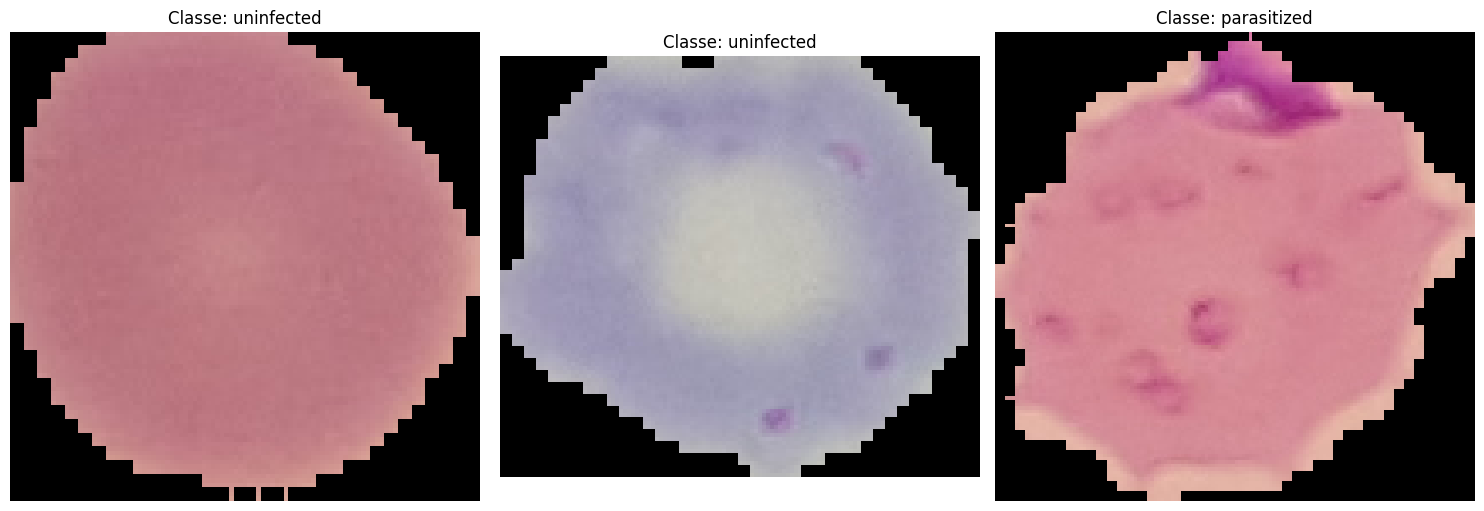

In [4]:
analyzer.show_sample_images()

### Analyse des tailles d'images
> Examinons maintenant la distribution des tailles d'images dans notre dataset. Cela nous aidera à comprendre les variations possibles dans les dimensions des images et à déterminer si nous devons appliquer un redimensionnement uniforme.


Analyse des dimensions des images...

Statistiques des dimensions:

Hauteur (pixels):
  - Min: 40
  - Max: 385
  - Moyenne: 132.98
  - Médiane: 130.00
  - Écart-type: 20.62

Largeur (pixels):
  - Min: 46
  - Max: 394
  - Moyenne: 132.49
  - Médiane: 130.00
  - Écart-type: 20.02

Ratio d'aspect (largeur/hauteur):
  - Min: 0.46
  - Max: 2.59
  - Moyenne: 1.01
  - Médiane: 1.00

Nombre total de pixels:
  - Min: 2,200
  - Max: 123,760
  - Moyenne: 17,835.76


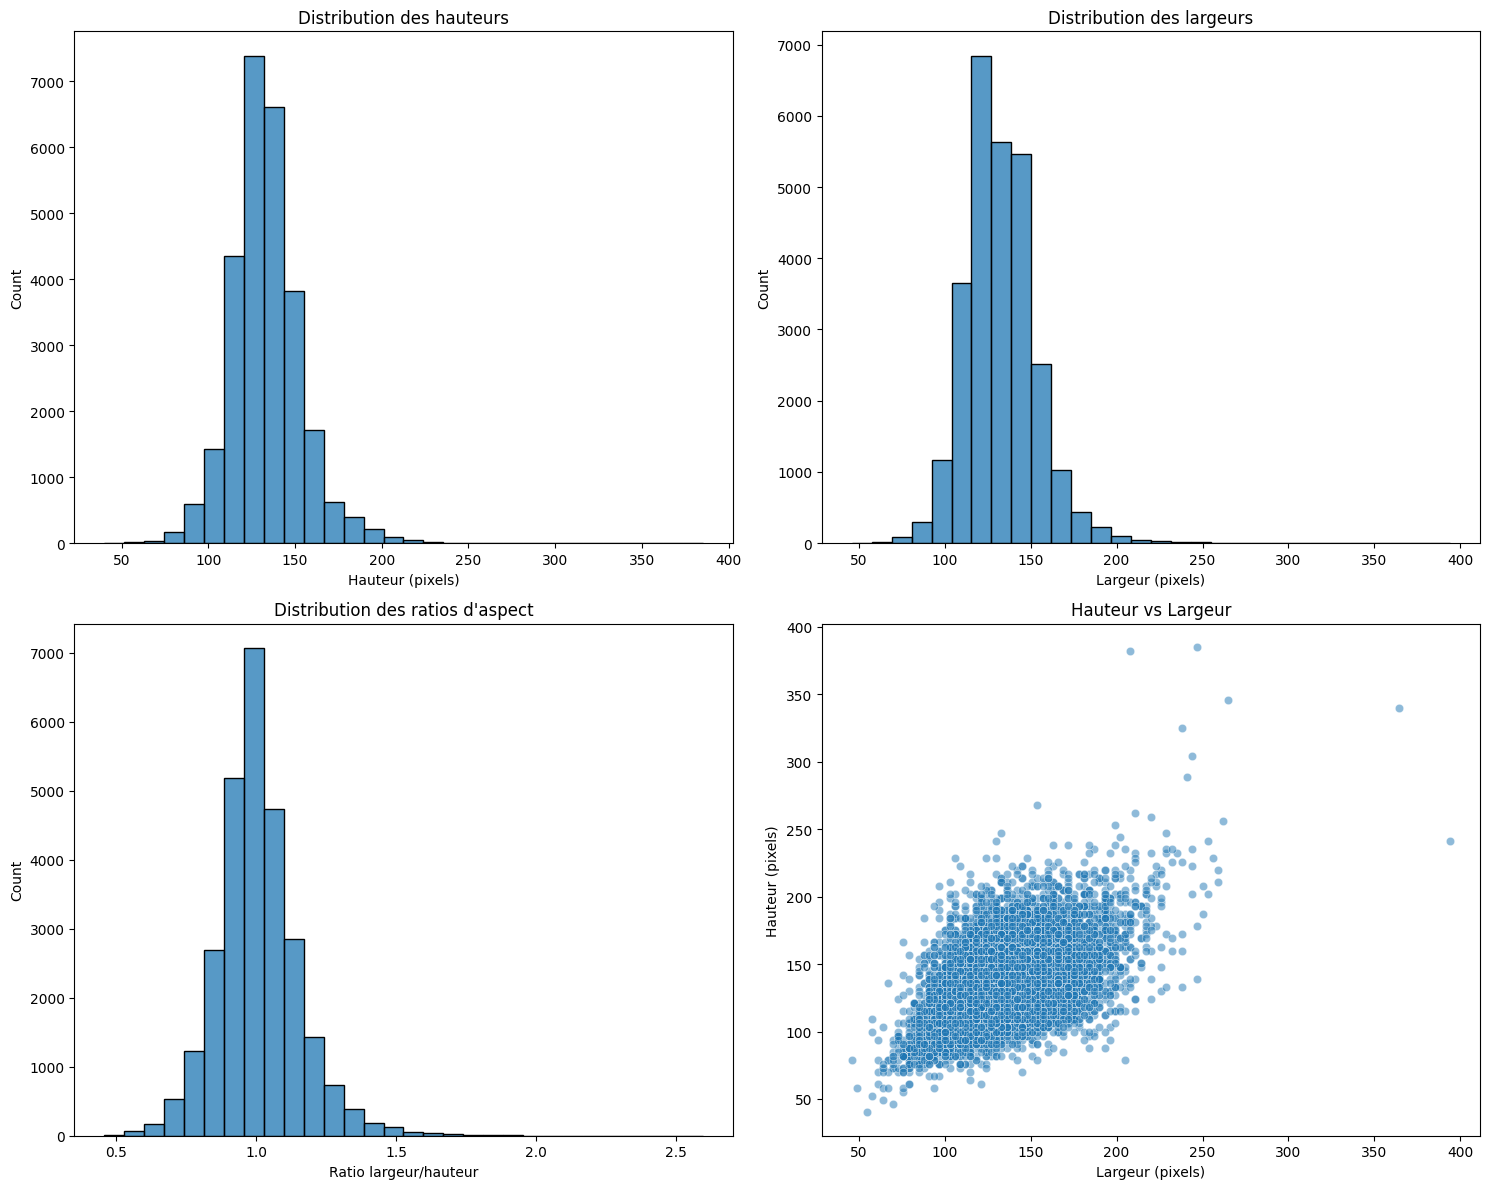


Dimensions les plus fréquentes (hauteur × largeur):
  130 × 130: 224 images (0.8%)
  124 × 127: 200 images (0.7%)
  130 × 127: 199 images (0.7%)
  124 × 124: 191 images (0.7%)
  127 × 124: 187 images (0.7%)


In [5]:
analyzer.analyze_image_sizes()

### Analyse de l'équilibre des classes
> Examinons maintenant l'équilibre des classes dans notre dataset. Cela nous aidera à comprendre si nous avons des classes sous-représentées ou sur-représentées et à ajuster nos données si nécessaire.

In [6]:
analyzer.analyze_class_balance()


Analyse de l'équilibre des classes sur l'ensemble du dataset:
parasitized:
  - Nombre d'images: 13779
  - Proportion: 50.00%
uninfected:
  - Nombre d'images: 13779
  - Proportion: 50.00%

Ratio de déséquilibre (max/min): 1.00


### Analyse des caractéristiques des images
> Examinons maintenant les caractéristiques des images dans notre dataset. Cela nous aidera à comprendre les variations possibles dans les caractéristiques des images et à déterminer si nous devons appliquer un prétraitement spécifique.

C:\Users\sebas\AppData\Local\Temp\ipykernel_44500\1072839015.py:227: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
C:\Users\sebas\AppData\Local\Temp\ipykernel_44500\1072839015.py:238: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
C:\Users\sebas\AppData\Local\Temp\ipykernel_44500\1072839015.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)


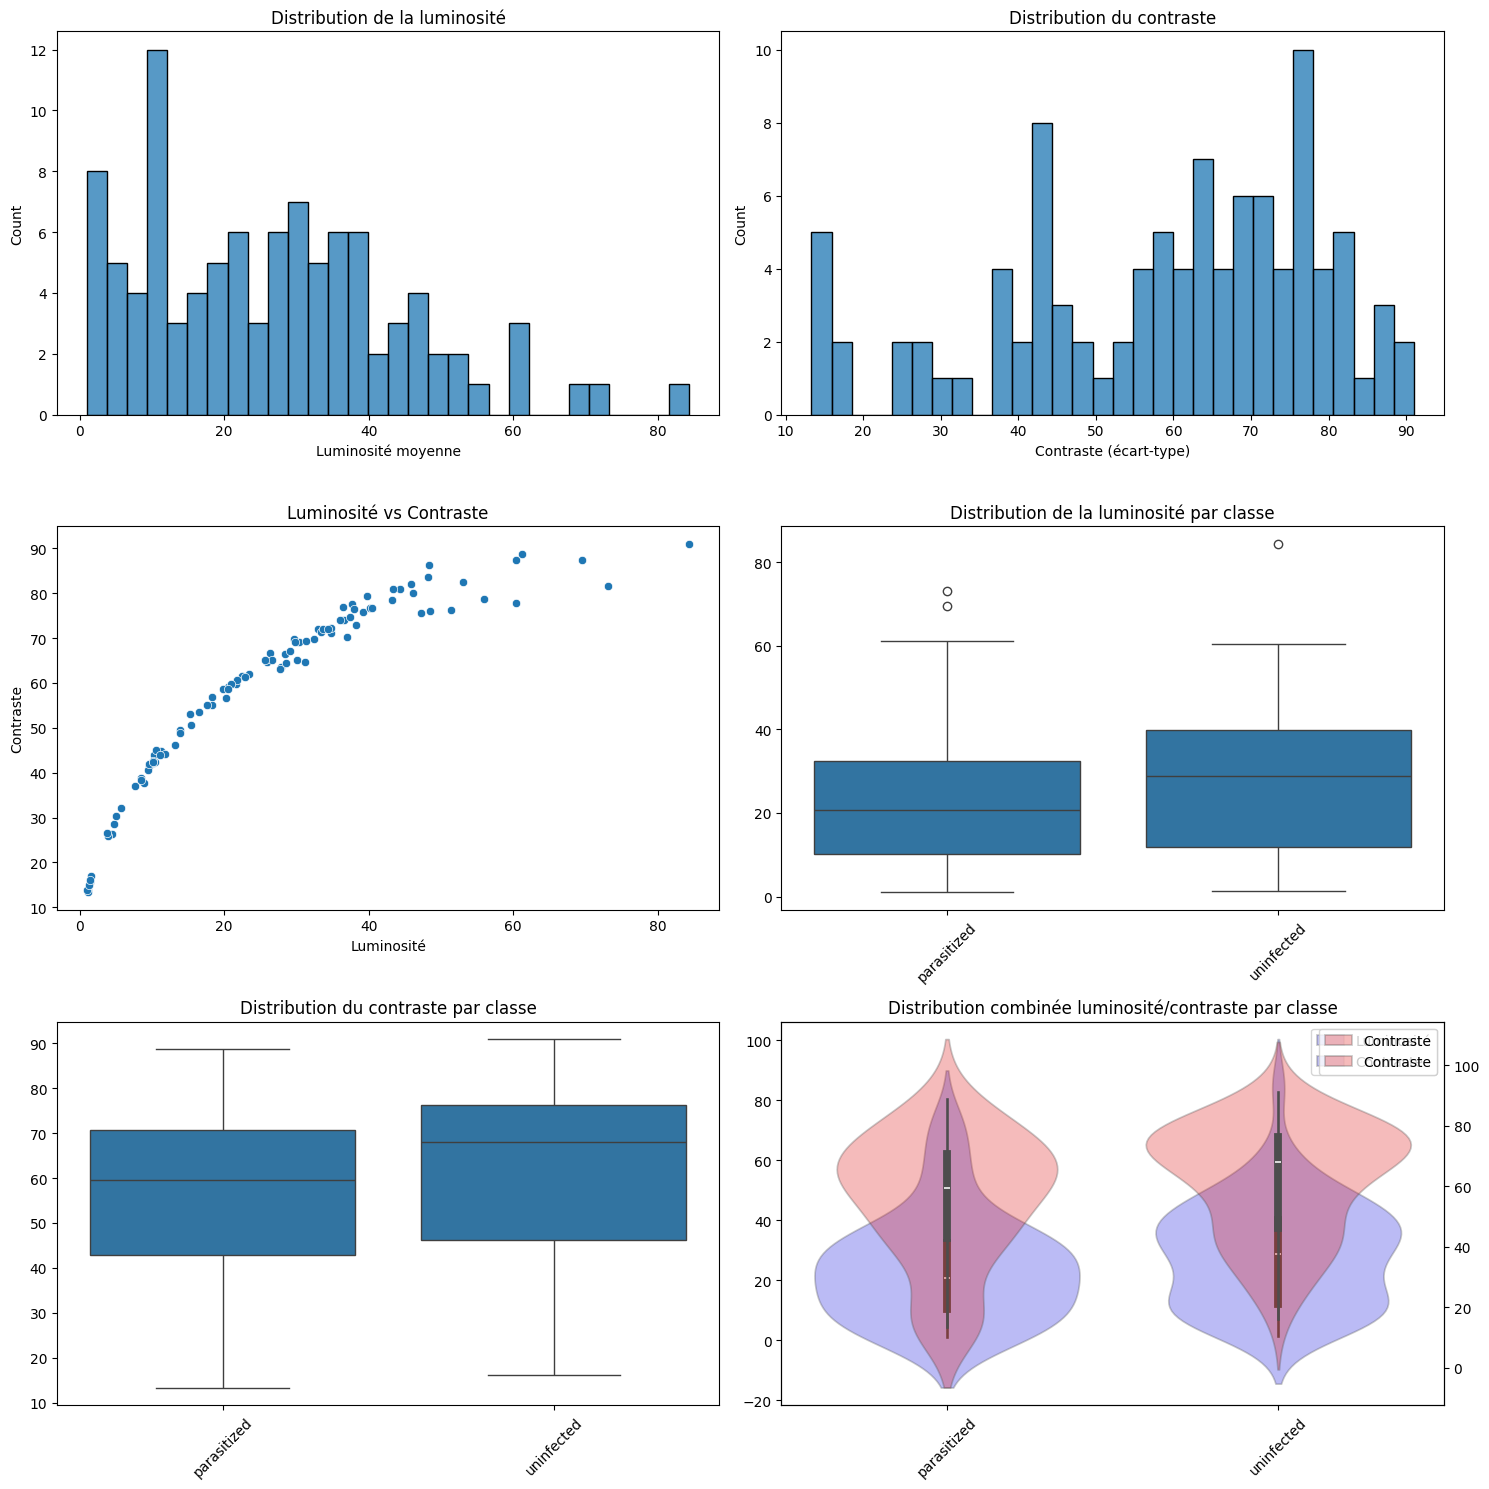


Statistiques par classe:

Classe: parasitized
Luminosité - Moyenne: 24.076, Écart-type: 17.866
Contraste  - Moyenne: 55.221, Écart-type: 21.090

Classe: uninfected
Luminosité - Moyenne: 28.706, Écart-type: 17.536
Contraste  - Moyenne: 61.909, Écart-type: 18.372


In [7]:
analyzer.analyze_image_characteristics()

#### Interprétation des caractéristiques des images
 > L'analyse des caractéristiques des images nous révèle plusieurs points intéressants :
 >
 > **Luminosité :**
 > - Les cellules parasitées ont tendance à être légèrement plus sombres en moyenne
 > - La distribution de la luminosité est plus étalée pour les cellules parasitées, suggérant une plus grande variabilité
 >
 > **Contraste :**
 > - Les cellules parasitées montrent un contraste plus élevé en moyenne
 > - Cette différence de contraste s'explique probablement par la présence du parasite qui crée des zones plus sombres dans l'image
 >
 > **Relation luminosité/contraste :**
 > - On observe une corrélation négative entre luminosité et contraste
 > - Les images plus sombres ont tendance à avoir un contraste plus élevé
 >
 > Ces différences de caractéristiques pourront être exploitées par notre modèle pour distinguer les cellules saines des cellules parasitées.



### Analyse de la distribution des couleurs
> Examinons maintenant la distribution des couleurs dans notre dataset. Cela nous aidera à comprendre les variations possibles dans les couleurs des images et à déterminer si nous devons appliquer un prétraitement spécifique.


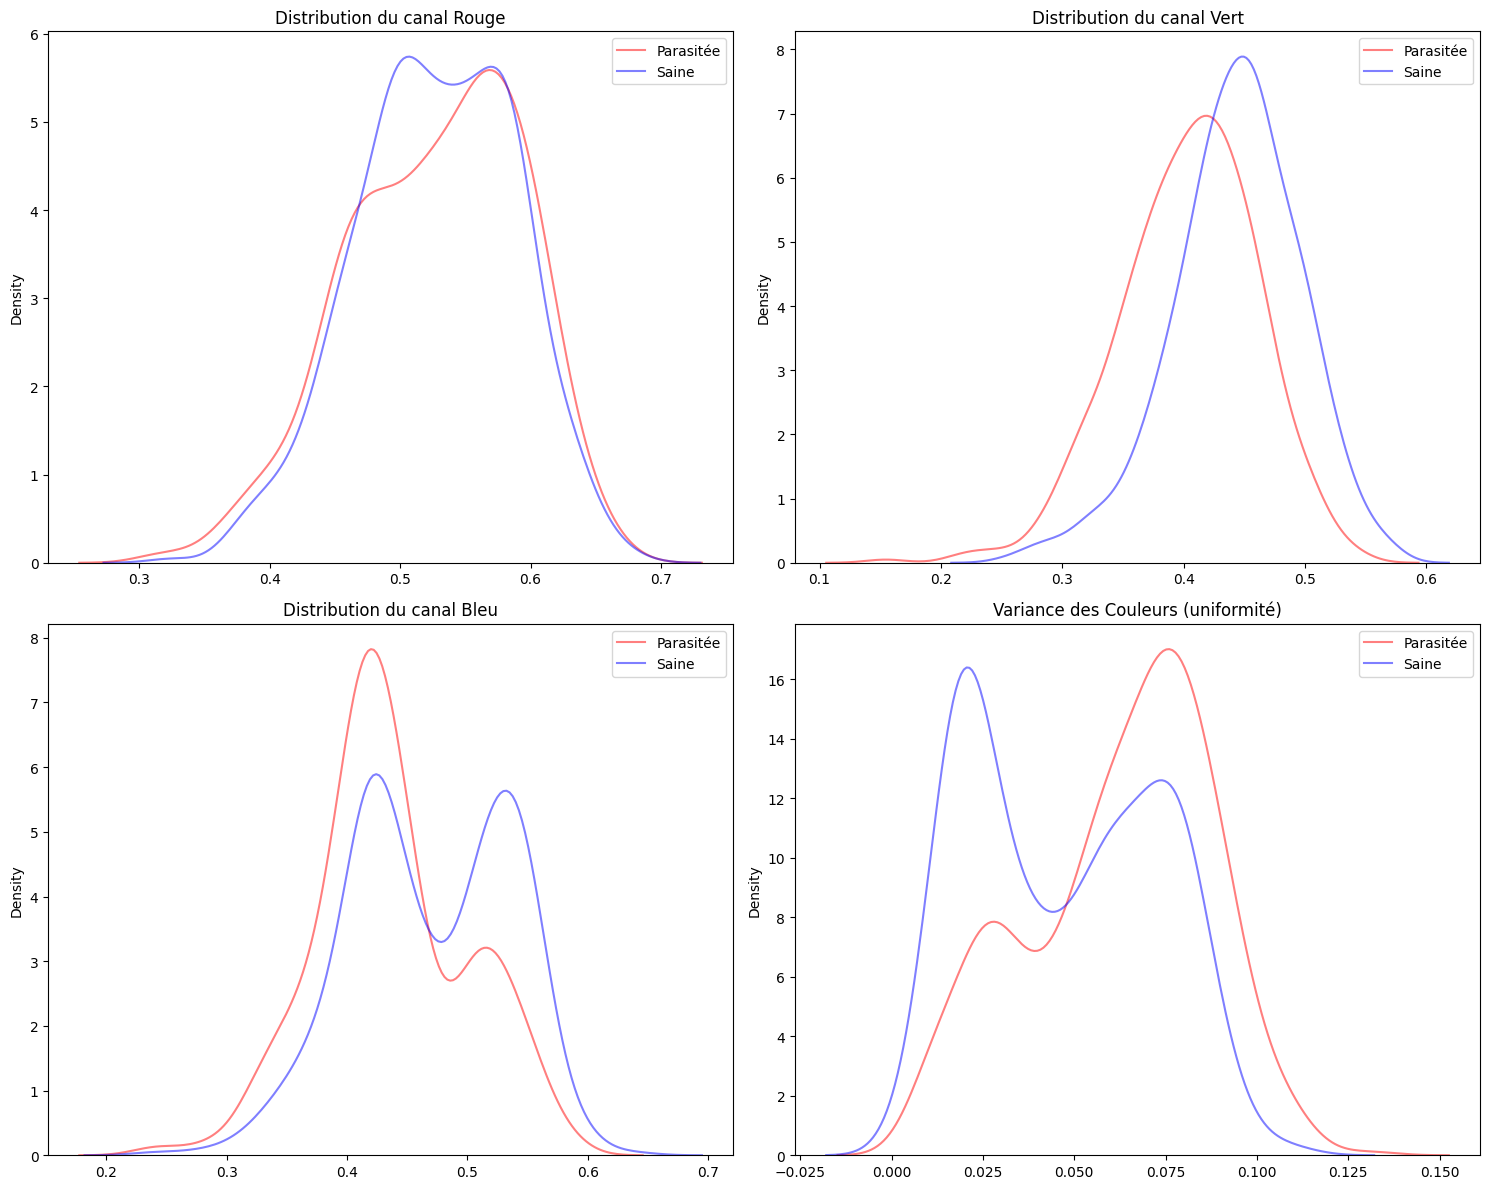


Statistiques des couleurs par classe:

Classe: parasitized
Canal Rouge - Moyenne: 0.527, Écart-type: 0.067
Canal Vert - Moyenne: 0.404, Écart-type: 0.057
Canal Bleu - Moyenne: 0.436, Écart-type: 0.063
Variance des couleurs - Moyenne: 0.062, Écart-type: 0.025

Classe: uninfected
Canal Rouge - Moyenne: 0.527, Écart-type: 0.060
Canal Vert - Moyenne: 0.443, Écart-type: 0.053
Canal Bleu - Moyenne: 0.469, Écart-type: 0.066
Variance des couleurs - Moyenne: 0.047, Écart-type: 0.026


In [8]:
analyzer.analyze_color_distribution()

#### Interprétation de la distribution des couleurs
> L'analyse de la distribution des couleurs révèle des différences notables entre les cellules saines et parasitées :
> - Les cellules saines montrent une distribution plus uniforme des couleurs vertes, avec des pics plus prononcés dans les canaux G (vert) et R (rouge).
> - Les cellules parasitées présentent une distribution plus irrégulière, avec :
>   - Une diminution générale de l'intensité du vert
>   - Des pics plus prononcés dans les tons bruns/jaunâtres (mélange de R et G plus faible)
>   - Une plus grande variabilité dans les distributions, reflétant les différents stades de la maladie
> Ces différences de signatures colorimétriques pourront être exploitées par notre modèle pour la classification.



## Prétraitement des données
> Maintenant que nous avons analysé les données brutes, nous allons les prétraiter pour les rendre plus adaptées à l'entraînement de notre modèle.

In [16]:
class DatasetPreparator:
    """Classe dédiée à la préparation et l'analyse des données prétraitées"""
    def __init__(self, img_size=128, batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.ds_train = None
        self.ds_val = None
        self.info = None
        
    def load_and_split_data(self, train_split=0.8):
        """Charge et divise les données en train/val"""
        # Charger les données avec split
        (self.ds_train, self.ds_val), self.info = tfds.load(
            'malaria',
            split=['train[:80%]', 'train[80%:]'],
            with_info=True,
            as_supervised=True
        )
        
    def preprocess(self, image, label):
        """Prétraite une image"""
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [self.img_size, self.img_size])
        image = image / 255.0
        return image, label
        
    def prepare_datasets(self):
        """Prépare les datasets pour l'entraîment"""
        AUTOTUNE = tf.data.AUTOTUNE
        
        # Ajout de l'augmentation de données
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1),
        ])

        def augment(image, label):
            return data_augmentation(image), label

        # Dataset d'entraîment
        self.ds_train = self.ds_train.map(self.preprocess, num_parallel_calls=AUTOTUNE)
        self.ds_train = self.ds_train.map(augment, num_parallel_calls=AUTOTUNE)
        self.ds_train = self.ds_train.shuffle(1000)
        self.ds_train = self.ds_train.batch(self.batch_size)
        self.ds_train = self.ds_train.prefetch(AUTOTUNE)

        # Dataset de validation
        self.ds_val = self.ds_val.map(self.preprocess, num_parallel_calls=AUTOTUNE)
        self.ds_val = self.ds_val.batch(self.batch_size)
        self.ds_val = self.ds_val.prefetch(AUTOTUNE)
    
    def analyze_processed_image_sizes(self):
        """Analyse la distribution des tailles d'images après prétraitement"""
        heights = []
        widths = []
        aspect_ratios = []
        total_pixels = []
        total_images = 0
        
        print("\nAnalyse des dimensions des images après prétraitement...")
        
        # Analyser tout le dataset prétraité
        for images, _ in self.ds_train:
            for image in images:
                shape = tf.shape(image)
                h, w = shape[0], shape[1]
                heights.append(h.numpy())
                widths.append(w.numpy())
                aspect_ratios.append(w.numpy() / h.numpy())
                total_pixels.append((w.numpy() * h.numpy()))
                total_images += 1
        
        print(f"\nNombre total d'images analysées: {total_images}")
        
        heights = np.array(heights)
        widths = np.array(widths)
        aspect_ratios = np.array(aspect_ratios)
        total_pixels = np.array(total_pixels)
        
        # Statistiques détaillées
        print("\nStatistiques des dimensions après prétraitement:")
        print("\nHauteur (pixels):")
        print(f"  - Min: {heights.min()}")
        print(f"  - Max: {heights.max()}")
        print(f"  - Moyenne: {heights.mean():.2f}")
        print(f"  - Médiane: {np.median(heights):.2f}")
        print(f"  - Écart-type: {heights.std():.2f}")
        
        print("\nLargeur (pixels):")
        print(f"  - Min: {widths.min()}")
        print(f"  - Max: {widths.max()}")
        print(f"  - Moyenne: {widths.mean():.2f}")
        print(f"  - Médiane: {np.median(widths):.2f}")
        print(f"  - Écart-type: {widths.std():.2f}")
        
        print("\nRatio d'aspect (largeur/hauteur):")
        print(f"  - Min: {aspect_ratios.min():.2f}")
        print(f"  - Max: {aspect_ratios.max():.2f}")
        print(f"  - Moyenne: {aspect_ratios.mean():.2f}")
        print(f"  - Médiane: {np.median(aspect_ratios):.2f}")
        
        # Visualisations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Distribution des hauteurs
        sns.histplot(heights, ax=ax1, bins=30)
        ax1.set_title('Distribution des hauteurs après prétraitement')
        ax1.set_xlabel('Hauteur (pixels)')
        
        # Distribution des largeurs
        sns.histplot(widths, ax=ax2, bins=30)
        ax2.set_title('Distribution des largeurs après prétraitement')
        ax2.set_xlabel('Largeur (pixels)')
        
        # Distribution des ratios d'aspect
        sns.histplot(aspect_ratios, ax=ax3, bins=30)
        ax3.set_title('Distribution des ratios d\'aspect après prétraitement')
        ax3.set_xlabel('Ratio largeur/hauteur')
        
        # Relation hauteur/largeur
        sns.scatterplot(x=widths, y=heights, ax=ax4, alpha=0.5)
        ax4.set_title('Hauteur vs Largeur après prétraitement')
        ax4.set_xlabel('Largeur (pixels)')
        ax4.set_ylabel('Hauteur (pixels)')
        
        plt.tight_layout()
        plt.show()

    def get_prepared_datasets(self):
        """Retourne les datasets préparés"""
        return self.ds_train, self.ds_val


### Analyse des tailles d'images après prétraitement
> Vérifions maintenant la distribution des tailles d'images après prétraitement.



Analyse des dimensions des images après prétraitement...

Nombre total d'images analysées: 22046

Statistiques des dimensions après prétraitement:

Hauteur (pixels):
  - Min: 128
  - Max: 128
  - Moyenne: 128.00
  - Médiane: 128.00
  - Écart-type: 0.00

Largeur (pixels):
  - Min: 128
  - Max: 128
  - Moyenne: 128.00
  - Médiane: 128.00
  - Écart-type: 0.00

Ratio d'aspect (largeur/hauteur):
  - Min: 1.00
  - Max: 1.00
  - Moyenne: 1.00
  - Médiane: 1.00


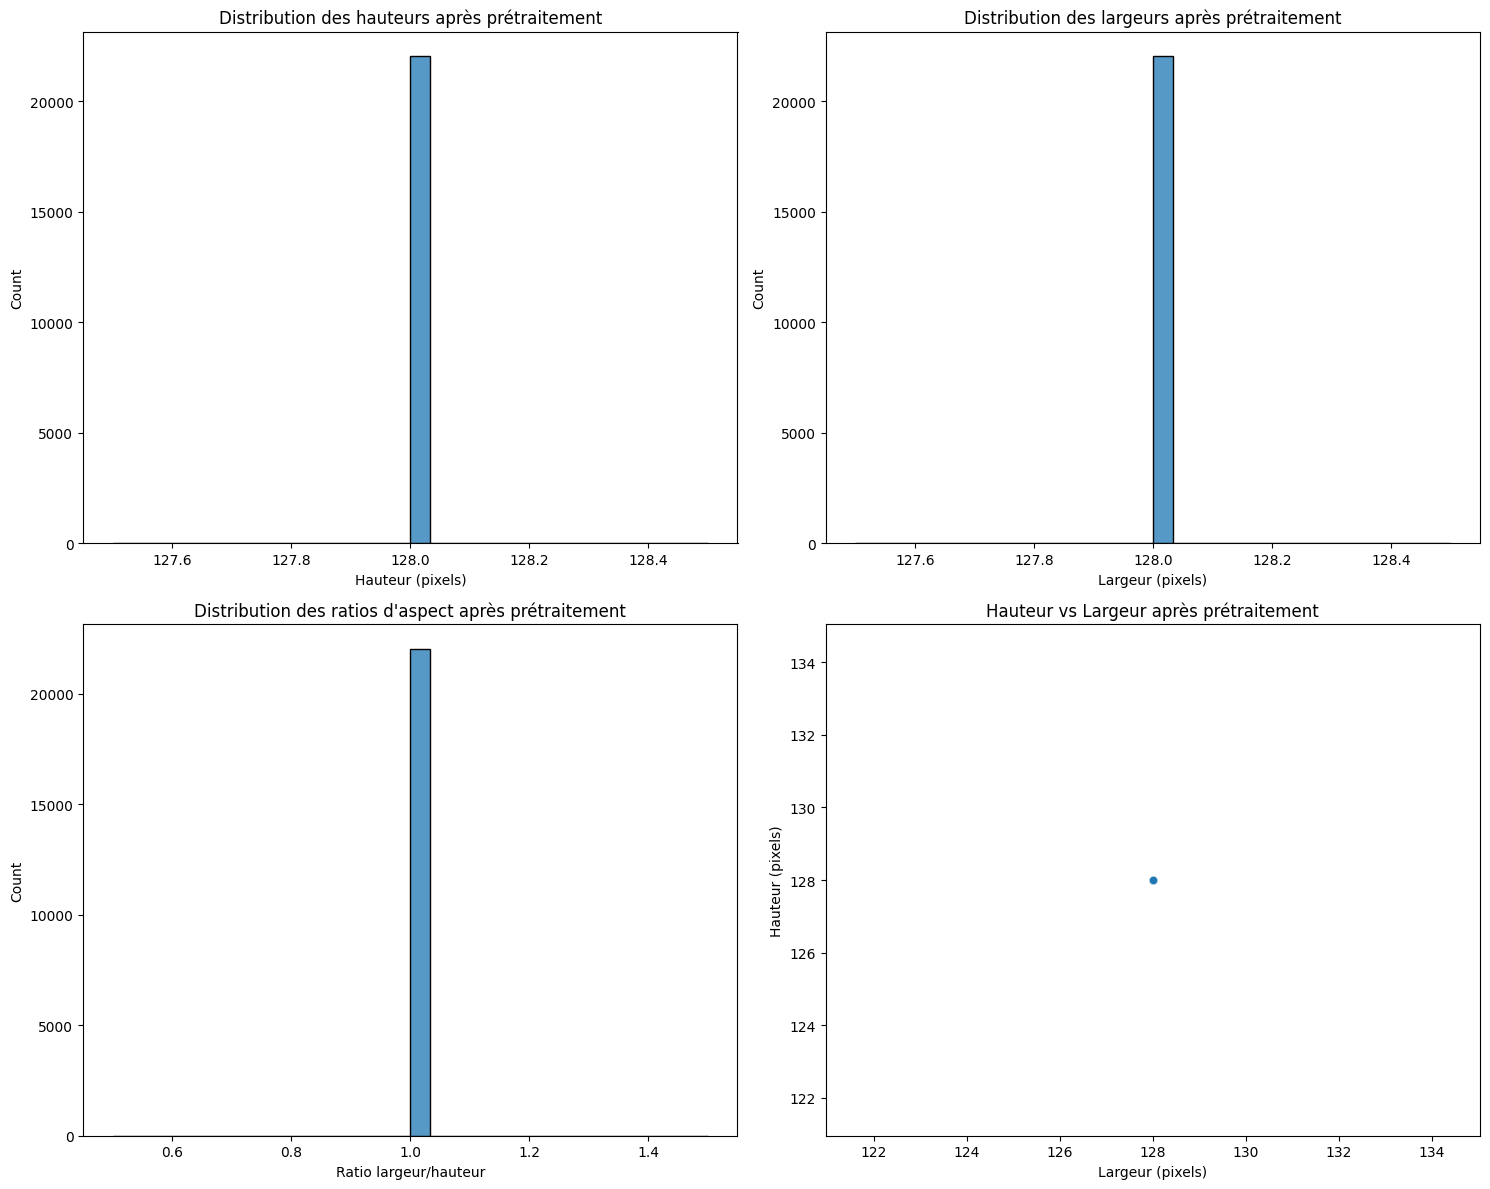

In [17]:
preparator = DatasetPreparator()
preparator.load_and_split_data()
preparator.prepare_datasets()
preparator.analyze_processed_image_sizes()

## Entraînement du modèle
> Maintenant que nos données sont préparées, nous allons entraîner un modèle de classification.


In [11]:
class ModelTrainer:
    """Classe dédiée à la conception, l'entraînement et l'évaluation des modèles"""
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.model_name = "malaria_detector"
        
    def build_model(self):
        """Construit un modèle CNN avancé"""
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def train_model(self, train_dataset, val_dataset, epochs=15):
        """Entraîne le modèle sur le dataset d'entraîment"""
        # Callbacks pour l'arrêt précoce et le réglage du taux d'apprentissage
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        
        self.model.fit(train_dataset, 
                       validation_data=val_dataset, 
                       epochs=epochs, 
                       callbacks=[early_stopping, lr_scheduler])

    def evaluate_model(self, test_dataset):
        """Évalue le modèle sur le dataset de test"""
        loss, accuracy = self.model.evaluate(test_dataset)
        print(f"Test Loss: {loss}")
        print(f"Test Accuracy: {accuracy}")

    def save_model(self, output_dir='models'):
        """Sauvegarde le modèle et ses poids"""
        if self.model is None:
            raise ValueError("Aucun modèle à sauvegarder")
            
        # Créer le dossier de sortie s'il n'existe pas
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Sauvegarder le modèle complet (architecture + poids + optimiseur)
        model_path = output_path / f"{self.model_name}_full.h5"
        self.model.save(model_path)
        print(f"\nModèle complet sauvegardé dans: {model_path}")
        
        # Sauvegarder uniquement les poids - correction de l'extension
        weights_path = output_path / f"{self.model_name}.weights.h5"  # Changement ici
        self.model.save_weights(weights_path)
        print(f"Poids du modèle sauvegardés dans: {weights_path}")
        
        # Sauvegarder l'architecture en JSON
        json_path = output_path / f"{self.model_name}_architecture.json"
        with open(json_path, 'w') as f:
            f.write(self.model.to_json())
        print(f"Architecture du modèle sauvegardée dans: {json_path}")
    
    def load_model(self, model_path):
        """Charge un modèle sauvegardé"""
        self.model = tf.keras.models.load_model(model_path)
        print(f"\nModèle chargé depuis: {model_path}")



=== Entraînement et évaluation du modèle ===
Epoch 1/15


c:\Users\sebas\PycharmProjects\malaria\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 216s 310ms/step - accuracy: 0.7346 - loss: 0.6697 - val_accuracy: 0.7195 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 202s 292ms/step - accuracy: 0.9212 - loss: 0.2358 - val_accuracy: 0.9318 - val_loss: 0.1976 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 214s 310ms/step - accuracy: 0.9381 - loss: 0.1883 - val_accuracy: 0.9316 - val_loss: 0.1851 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 199s 288ms/step - accuracy: 0.9464 - loss: 0.1620 - val_accuracy: 0.9146 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 201s 291ms/step - accuracy: 0.9499 - loss: 0.1556 - val_accuracy: 0.9356 - val_loss: 0.1828 - learning_rate: 0.0010
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 201s 290ms/step - accuracy: 0.9508 - loss: 0.1479 - val_accuracy: 0.9507 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 201s 290ms/step - accuracy: 0.9527 

AttributeError: 'ModelTrainer' object has no attribute 'history'

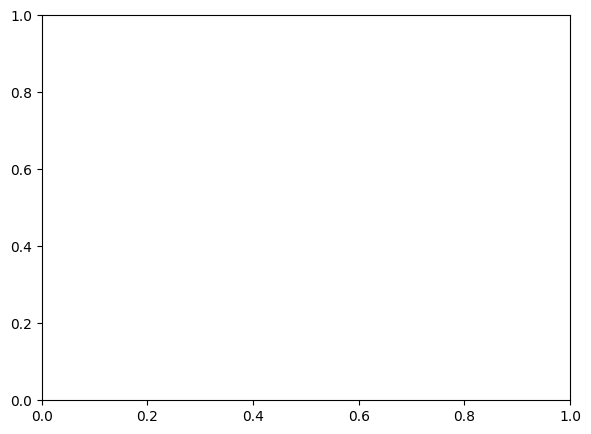

In [18]:
# Entraînement et évaluation du modèle
print("\n=== Entraînement et évaluation du modèle ===")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 2
trainer = ModelTrainer(input_shape, num_classes)
trainer.build_model()
trainer.train_model(preparator.ds_train, preparator.ds_val)
trainer.evaluate_model(preparator.ds_val)

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(15, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(trainer.history.history['loss'], label='Perte (entraînement)')
plt.plot(trainer.history.history['val_loss'], label='Perte (validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(trainer.history.history['accuracy'], label='Précision (entraînement)')
plt.plot(trainer.history.history['val_accuracy'], label='Précision (validation)')
plt.title('Évolution de la précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Sauvegarde du modèle
> Sauvegardons maintenant notre modèle pour pouvoir l'utiliser dans notre application.


In [23]:
# Sauvegarder le modèle
print("\n=== Sauvegarde du modèle ===")
trainer.save_model(output_dir='outputs/models')

# Sauvegarder le modèle au format .keras (plus léger)
keras_path = Path('outputs/models') / f"{trainer.model_name}.keras"
trainer.model.save(keras_path, save_format='keras')
print(f"\nModèle léger sauvegardé au format .keras dans: {keras_path}")

# Optimisation de la taille du modèle
print("\n=== Optimisation de la taille du modèle ===")

# 1. Convertir en TFLite pour réduire la taille
converter = tf.lite.TFLiteConverter.from_keras_model(trainer.model)

# Activer les optimisations par défaut
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Quantification en int8 pour réduire davantage la taille
converter.target_spec.supported_types = [tf.float16]
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
#converter.representative_dataset = lambda: [next(iter(preparator.ds_val))[0] for _ in range(100)]

# Convertir le modèle
tflite_model = converter.convert()

# Sauvegarder le modèle optimisé
tflite_path = Path('outputs/models') / f"{trainer.model_name}_optimized.tflite"
tflite_path.parent.mkdir(parents=True, exist_ok=True)
tflite_path.write_bytes(tflite_model)

# Afficher les tailles des différents formats
keras_size = keras_path.stat().st_size / (1024 * 1024)  # Taille en Mo
tflite_size = tflite_path.stat().st_size / (1024 * 1024)  # Taille en Mo

print(f"\nTaille du modèle Keras: {keras_size:.2f} Mo")
print(f"Taille du modèle TFLite optimisé: {tflite_size:.2f} Mo")
print(f"Taux de compression: {(keras_size/tflite_size):.1f}x")

print("\n=== Optimisation supplémentaire du modèle ===")

# Créer un nouveau convertisseur avec des optimisations plus agressives
converter_optimized = tf.lite.TFLiteConverter.from_keras_model(trainer.model)

# Activer toutes les optimisations possibles
converter_optimized.optimizations = [tf.lite.Optimize.DEFAULT]

# Quantification complète en int8
converter_optimized.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_optimized.inference_input_type = tf.int8  
converter_optimized.inference_output_type = tf.int8

# Définir un dataset représentatif pour la calibration
def representative_dataset():
    for images, _ in preparator.ds_val.take(100):
        yield [images]
        
converter_optimized.representative_dataset = representative_dataset

# Convertir le modèle avec quantification int8
tflite_model_int8 = converter_optimized.convert()

# Sauvegarder le modèle ultra-optimisé
tflite_int8_path = Path('outputs/models') / f"{trainer.model_name}_ultra_optimized.tflite"
tflite_int8_path.write_bytes(tflite_model_int8)

# Comparer les tailles
tflite_int8_size = tflite_int8_path.stat().st_size / (1024 * 1024)
print(f"\nTaille du modèle TFLite int8: {tflite_int8_size:.2f} Mo")
print(f"Taux de compression vs Keras: {(keras_size/tflite_int8_size):.1f}x")
print(f"Taux de compression vs TFLite float16: {(tflite_size/tflite_int8_size):.1f}x")
print("\n=== Optimisation finale avec pruning ===")

# Créer un nouveau convertisseur avec pruning
converter_pruned = tf.lite.TFLiteConverter.from_keras_model(trainer.model)

# Activer toutes les optimisations possibles
converter_pruned.optimizations = [tf.lite.Optimize.DEFAULT]

# Quantification int8 + activation du pruning
converter_pruned.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_pruned.inference_input_type = tf.int8
converter_pruned.inference_output_type = tf.int8
converter_pruned.experimental_new_converter = True

# Activer des optimisations agressives supplémentaires
converter_pruned.target_spec.supported_types = [tf.int8]
converter_pruned.allow_custom_ops = False
converter_pruned.experimental_new_quantizer = True

# Utiliser le même dataset représentatif
converter_pruned.representative_dataset = representative_dataset

# Convertir avec toutes les optimisations
tflite_model_pruned = converter_pruned.convert()

# Compression supplémentaire avec zlib
import zlib
tflite_compressed = zlib.compress(tflite_model_pruned, level=9)

# Sauvegarder le modèle ultra-compressé
tflite_pruned_path = Path('outputs/models') / f"{trainer.model_name}_final_optimized.tflite.gz"
tflite_pruned_path.write_bytes(tflite_compressed)

# Comparer les tailles
tflite_pruned_size = tflite_pruned_path.stat().st_size / (1024 * 1024)
print(f"\nTaille du modèle TFLite final: {tflite_pruned_size:.2f} Mo")
print(f"Taux de compression vs Keras: {(keras_size/tflite_pruned_size):.1f}x")
print(f"Taux de compression vs TFLite int8: {(tflite_int8_size/tflite_pruned_size):.1f}x")

print("\nNote: Le modèle compressé devra être décompressé avant utilisation")




=== Sauvegarde du modèle ===

Modèle complet sauvegardé dans: outputs\models\malaria_detector_full.h5


Poids du modèle sauvegardés dans: outputs\models\malaria_detector.weights.h5
Architecture du modèle sauvegardée dans: outputs\models\malaria_detector_architecture.json

Modèle léger sauvegardé au format .keras dans: outputs\models\malaria_detector.keras

=== Optimisation de la taille du modèle ===
INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpu5xrra33\assets


INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpu5xrra33\assets


Saved artifact at 'C:\Users\sebas\AppData\Local\Temp\tmpu5xrra33'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2088013327120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013327888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013329616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013330768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013331152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013329232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20

INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpiyo75b76\assets


Saved artifact at 'C:\Users\sebas\AppData\Local\Temp\tmpiyo75b76'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2088013327120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013327888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013329616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013330768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013331152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013329232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20

c:\Users\sebas\PycharmProjects\malaria\env\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Taille du modèle TFLite int8: 6.23 Mo
Taux de compression vs Keras: 12.0x
Taux de compression vs TFLite float16: 2.0x

=== Optimisation finale avec pruning ===
INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpykcso8n7\assets


INFO:tensorflow:Assets written to: C:\Users\sebas\AppData\Local\Temp\tmpykcso8n7\assets


Saved artifact at 'C:\Users\sebas\AppData\Local\Temp\tmpykcso8n7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2088013327120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013327888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013328656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013329616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013330768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013331152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088013329232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20

c:\Users\sebas\PycharmProjects\malaria\env\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Taille du modèle TFLite final: 5.27 Mo
Taux de compression vs Keras: 14.2x
Taux de compression vs TFLite int8: 1.2x

Note: Le modèle compressé devra être décompressé avant utilisation
